# Object Oriented Space Elevator Model

An OO Python space elevator model has been developed. This problem lends itself well to OO as each link in the chain can be discretized and several unique but similar object types provide a suitable use case for inheritance. 

**The purpose of this notebook is to apply the custom made classes defined in `elements.py`**


In reality, this problem is solved by physics in closed form discussed below, so simple inspection and manipulation of the algebra and calculus can provide sufficient analysis.

This notebook shows that by using a rudimentary finite element model – with solid OO principles- we can obtain similar results. 
 
If the problem were not steady state dynamics, such as a falling or unbalanced space elevator, basic physics equilibrium equations would no longer apply. Highly complex equations such as the Laplacian and other equations of motion could be applied. In these cases, a discrete element model may help solve the problem. If not more quickly certainly more intuitively 


In [1]:
import numpy as np
import elements
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Set Earth As Central Body
# Length Resolution of 100 km
cb = elements.CentralBody()
unit_length = 100e3 # To course for good results, but quick!
geo_orbit = 42000e3
phys_prop = elements.LinkPhysicalProperties(unit_length=unit_length, diamter=20, density=7900)
cable_mass_geo = geo_orbit * phys_prop.cross_sectional_area * phys_prop.density

# Model Validation

Derive the Tension Delta for an elevator with no Counter mass. Similair to the derivation in Section II of this [this](https://users.wpi.edu/~paravind/Publications/PKASpace%20Elevators.pdf) paper. In this notebook, positive stress is Tension, and is desirable in a cable as cables collapse uner compression. 

$
\large
-m\omega^2r  = T_{above} - T_{below} - W
$

$
W - m\omega^2r = \Delta T
$

$
m(\frac{\mu}{r^2} - \omega^2r) = \Delta T
$


$
A\rho dr(\frac{\mu}{r^2} - \omega^2r) = dT
$

$
\frac{dT}{dr}=A\rho(\frac{\mu}{r^2} - \omega^2r)
$

$
\int_{T_e}^{T_{r}}dT = \int_{R_e}^{L_{cable}}A\rho(\frac{\mu}{r^2} - \omega^2r)dr
$


$
T(r)-T_e=\left[A\rho\left(\frac{-\mu}{r}-\frac{r^2}{2}\omega^2\right)\right]_R^L
$


In [3]:
def dt_dr(r):
    return phys_prop.density * phys_prop.cross_sectional_area * ( (cb.mu / r **2) - (cb.omega[2] **2) *r) 

def tension_calc(r):
    return phys_prop.density * phys_prop.cross_sectional_area * (( -1 * r ** 2 *cb.omega[2]  ** 2 / 2 ) - (cb.mu / r))


In [4]:
cable_length = 150000E3
ev = elements.SpaceElevator(cable_length=cable_length, phys_prop=phys_prop, anchor_mass=0)
theory =  tension_calc(ev.radii[:,0]) - tension_calc(6378e3)

Text(0.5, 0, 'Radius From Center of the Earth (m)')

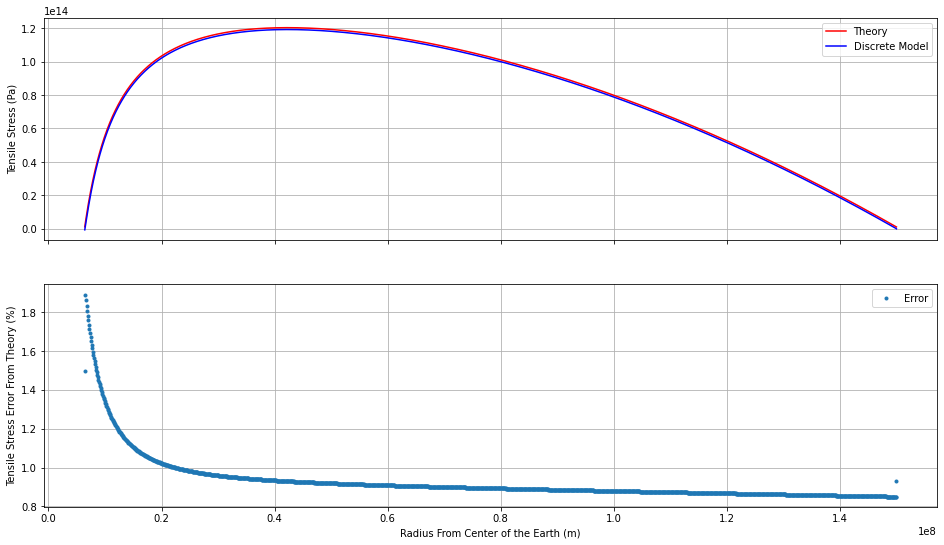

In [5]:
fig, ax = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=(16,9))

ax[0].plot(ev.radii[:,0], theory , 'r-', label='Theory')
ax[0].plot(ev.radii[:,0], ev.tensions[:,0], 'b-', label='Discrete Model')
ax[0].grid()
ax[1].plot(ev.radii[:,0], 100 * abs(ev.tensions[:,0] - theory)  / max(theory), '.', label='Error')
for i in [0,1]:
    ax[i].grid(True)
    ax[i].legend()
ax[0].set_ylabel('Tensile Stress (Pa)')
ax[1].set_ylabel('Tensile Stress Error From Theory (%)');
ax[1].set_xlabel('Radius From Center of the Earth (m)')

# Variation on Cable Length
For a cable with no anchor, what is the ideal mass. (Also discussed in paper above). From inspection of the graph below we that a cable between 3.2 - 3.7 Geo Radius will have a tension of 0 at the surface of the earth. 

According to the paper the answer to this problem is **144,000 km** Above the surface of the earth. This fits nicely between our 2 answers obtained with the OO model.

3.2 * r_geo - R_earth => 128,000 km  
3.7 * r_geo - R_earth => 149,000 km

Text(0.5, 0, 'Radius From Center of the Earth (m)')

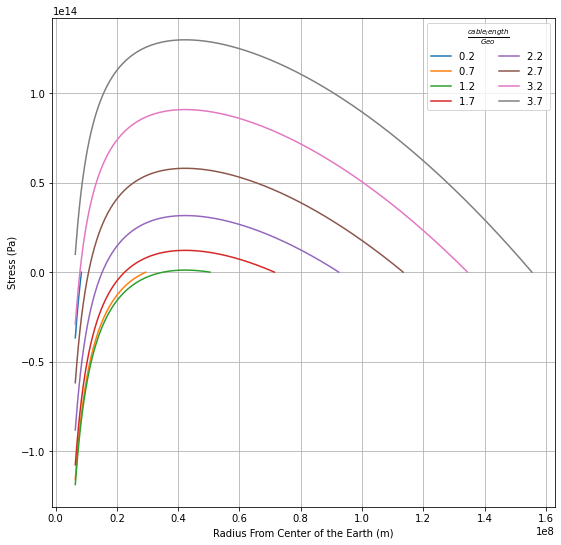

In [6]:
plt.figure(figsize=(9,9))
plt.grid()
anchor_mass = 0
for cable_length in np.arange(0.2, 4, 0.5) * geo_orbit:
    ev = elements.SpaceElevator(cable_length=cable_length, phys_prop=phys_prop, anchor_mass=anchor_mass)
    plt.plot(ev.radii[:,0], ev.tensions[:,0], '-', label=f'{cable_length/geo_orbit:1.1f} ')
plt.legend(title='$\\frac{cable_length}{Geo}$', ncol=2)
plt.ylabel('Stress (Pa)')
plt.xlabel('Radius From Center of the Earth (m)')

# Variation on Anchor Mass
We want to minimize Stress -Tensile or Compressive- in the cable. In other words, we want to find the the anchor weight for a given cable, that minimizes stress.

The graph below shows cables masses compared to the cable mass of a cable of constant physical properties going straight ot Geo.


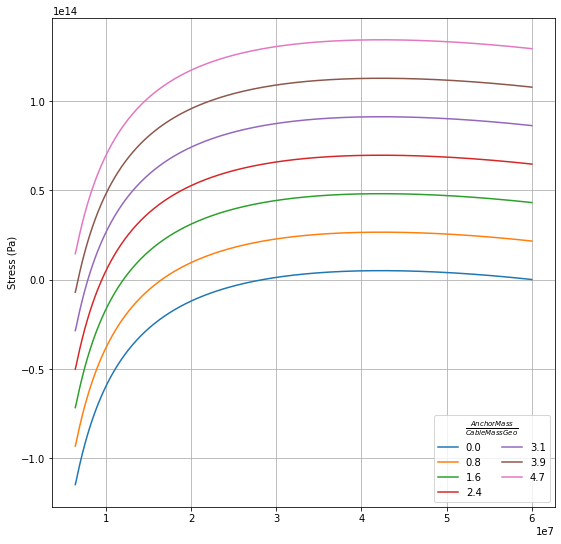

In [7]:
plt.figure(figsize=(9,9))
plt.grid()
cable_length = 60000e3
for anchor_mass in np.arange(0,7,1) * cable_mass_geo:
    ev = elements.SpaceElevator(cable_length=cable_length, phys_prop=phys_prop, anchor_mass=anchor_mass)
    plt.plot(ev.radii[:,0], ev.tensions[:,0], '-', label=f'{anchor_mass/ev.cable_mass:1.1f}')
plt.legend(title='$\\frac{AnchorMass}{CableMassGeo}$', ncol=2)
plt.ylabel('Stress (Pa)');

# Combining Cable Length and Anchor Mass

Suppose by a miracle of science we have a material which can withstand both tension and compression. In fact, it can even be tuned to handle a certain max compression and or tension. 

What would the properties of such a cable need to be to support a space evelator?

In [8]:
cable_lengths =  np.arange(1.0, 2.5, 0.05) * geo_orbit
aprox_anchor_masses = cable_lengths * phys_prop.cross_sectional_area * phys_prop.density
anchor_masses = np.arange(cable_mass_geo * 0,  cable_mass_geo * 2.1, 0.05 * cable_mass_geo)

max_tensile_stress = np.zeros((len(cable_lengths),len(anchor_masses)))
max_compressive_stress = np.zeros((len(cable_lengths),len(anchor_masses)))

for i, cable_length in enumerate(cable_lengths):
    for ii, anchor_mass in enumerate(anchor_masses):
        ev = elements.SpaceElevator(cable_length=cable_length, phys_prop=phys_prop, anchor_mass=anchor_mass)
        max_tensile_stress[i,ii] = ev.tensions.max() / phys_prop.cross_sectional_area
        max_compressive_stress[i,ii] = ev.tensions.min() / phys_prop.cross_sectional_area

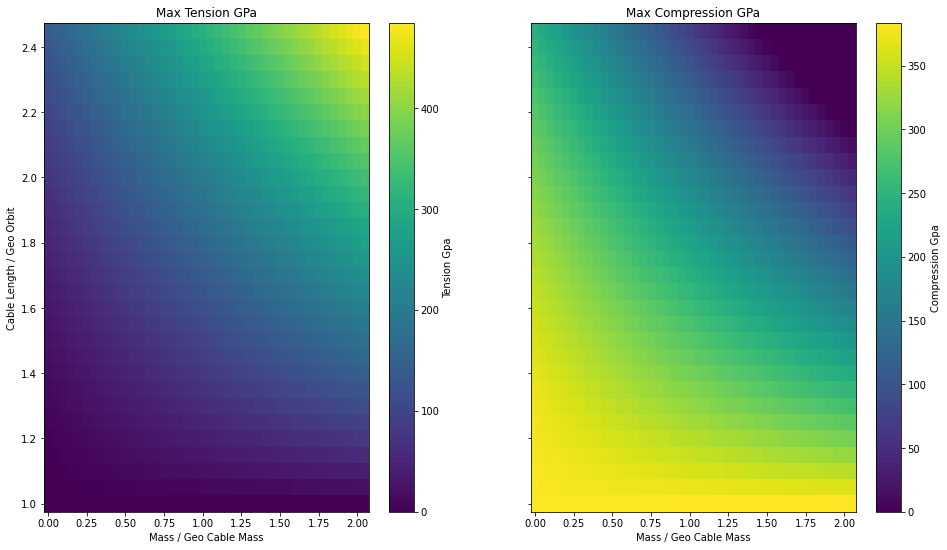

In [9]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16,9), sharex=True, sharey=True)

massmass, lenlen = np.meshgrid(anchor_masses, cable_lengths)
a = ax[0].pcolormesh(massmass / cable_mass_geo, lenlen / geo_orbit, max_tensile_stress / 1e9, shading='nearest')
ax[0].set_title('Max Tension GPa')

ax[0].set_ylabel('Cable Length / Geo Orbit')
ax[0].set_xlabel('Mass / Geo Cable Mass')
ax[1].set_xlabel('Mass / Geo Cable Mass')
b = ax[1].pcolormesh(massmass / cable_mass_geo, lenlen / geo_orbit, abs(max_compressive_stress / 1e9), shading='nearest')
ax[1].set_title('Max Compression GPa')
fig.colorbar(a, ax=ax[0], label='Tension Gpa')
fig.colorbar(b, ax=ax[1], label='Compression Gpa')